# Dopravní nehody v České republice za rok 2020

Z důvodu dopravních nehod zemře ročně v České republice velký počet lidí. Mnohonásobně vyšší počet osob je pak zraněn a finanční ztráty jsou taktéž enormní. V této krátké statistické studii budeme tato čísla vyhodnocovat. Hlavním cílem bude zjistit, co bylo příčinou nehod a zda není možné nehodám předejít. Zajímá nás, jak velkou roli hrál lidský faktor a zda by řidiče nebylo možné nahradit počítačem, který by mohl chybovost snížit. Může snaha automobilového průmyslu o vyrobení samoříditelných aut zachránit lidské životy? Pojďme se podívat.

Data pocházejí z [webu Policie ČR](https://www.policie.cz/clanek/statistika-nehodovosti-900835.aspx?q=Y2hudW09Mg%3d%3d).

Popis dat je [zde](https://www.policie.cz/soubor/polozky-formulare-hlavicky-souboru-xlsx.aspx).

In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

from os import listdir
from os.path import isfile, join

In [2]:
year = 2020

## Příprava dat

Zde si připravíme data. Musíme spojit soubory ze všech složek (reprezentující měsíce) a ze všech souborů v těch to složkách (reprezentující kraje).

In [3]:
data_folder = './data/' + str(year)
months_folders = [join(data_folder, month_folder) for month_folder in sorted(listdir(data_folder))]

In [4]:
files_desc = [
    "praha",
    "stredocesky",
    "jihocesky",
    "plzensky",
    "ustecky",
    "kralovehradecky",
    "jihomoravsky",
    "moravskoslezsky",
    "none",
    "none",
    "none",
    "none",
    "none",
    "none",
    "olomoucky",
    "zlinsky",
    "vysocina",
    "pradubicky",
    "liberecky",
    "karlovarsky",
    "chodci"
]

In [5]:
data = [] # pole mesicu (indexovano od nuly)
# data = [data_leden, data_unor, ...]
# data_leden = {"prazsky" = pdObject, "stredocesky" = pdObject, ...}

for m in months_folders:
    month_data = {} # data from each district
    for i, f in enumerate(sorted(listdir(m))):
        if files_desc[i] != "none" and files_desc[i] != "chodci":
            month_data[files_desc[i]] = pd.read_csv(join(m, f), sep=';', header=None, low_memory=False)
            month_data[files_desc[i]] = month_data[files_desc[i]].drop_duplicates(subset=[0])
    data.append(month_data)

all_data_pds = [m[kraj] for m in data for kraj in m]
all_data_with_duplicates = pd.concat(all_data_pds) # whole year, all districts
all_data = all_data_with_duplicates.drop_duplicates(subset=[0]) # drop duplicates (by id of the accident)

# Souhrnné statistiky

Pojďme se podívat na základní údaje o nehodách.

In [6]:
print(f"Za rok {year} \n - zemřelo {all_data[13].sum()} lidí, výběrový průměr na jeden den = {round(all_data[13].sum()/366, 2)} lidí\n\
 - bylo těžce zraněno {all_data[14].sum()} lidí, výběrový průměr na jeden den = {round(all_data[14].sum()/366, 2)} lidí\n\
 - bylo lehce zraněno {all_data[15].sum()} lidí, výběrový průměr na jeden den = {round(all_data[15].sum()/366, 2)} lidí\n\
 - újma na majetku činila {all_data[16].sum() // 1000} milionů Kč, výběrový průměr na jeden den = {round(all_data[16].sum()/(1000*366), 2)} milionů Kč\n\
 - celkem nehod bylo {all_data.shape[0]}, výběrový průměr na jeden den = {round(all_data[14].sum()/366, 2)} nehod")

Za rok 2020 
 - zemřelo 472 lidí, výběrový průměr na jeden den = 1.29 lidí
 - bylo těžce zraněno 1557 lidí, výběrový průměr na jeden den = 4.25 lidí
 - bylo lehce zraněno 21040 lidí, výběrový průměr na jeden den = 57.49 lidí
 - újma na majetku činila 60143 milionů Kč, výběrový průměr na jeden den = 164.33 milionů Kč
 - celkem nehod bylo 94804, výběrový průměr na jeden den = 4.25 nehod


Údaje jsou dány do 24h po nehodě. Dále se počty mohly změnit. Na těžké zranení mohly oběti nehod podlehnout i několik dní po incidentu,
to zde ale už započítáno není.

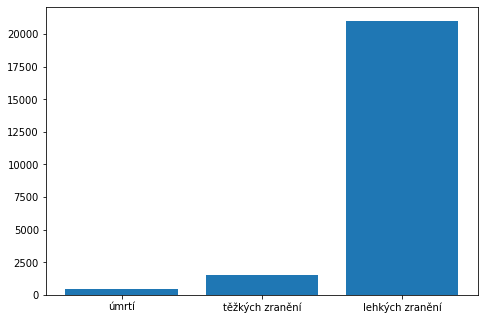

In [7]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
category = ['úmrtí', 'těžkých zranění', 'lehkých zranění']
numbers = [all_data[13].sum(), all_data[14].sum(), all_data[15].sum()]
ax.bar(category,numbers)
plt.show()

Podívejme se, kolik lidí při nehodě zemře, pokud se nehoda stane tragickou. V naprosté většině zemře jeden člověk.

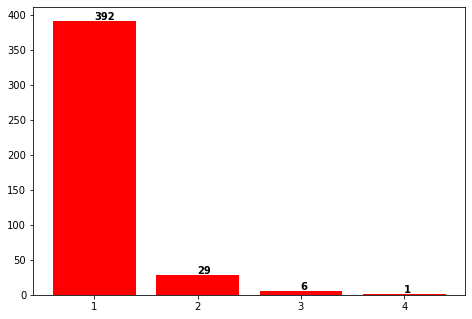

In [20]:
numbers = []
for num in range(1, all_data[13].max()+1):
    numbers.append(all_data[all_data[13] == num][13].count())

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
category = [str(i) for i in range(1, len(numbers)+1)]
ax.bar(category, numbers,color="r") #

for i in range(len(category)):
    ax.text(category[i], numbers[i] + 2, numbers[i], weight='bold')
plt.show()

# Zajímavé statistiky

Naše hypotéza je, že když mimo obec nehoda nastane, je většinou smrtelná. Tato domněnka vychází z faktu,
že mimo obec se smí jezdit až 90 km/h, zatímco v obci je rychlost omezena na 50 km/h. 

In [24]:
mimo_obec = all_data[all_data[63] == 1]
v_obci = all_data[all_data[63] == 2]

print(f"Nehod mimo obec: {mimo_obec.shape[0]}, pravděpodobnost úmrtí při srážce mimo obec {round(100*mimo_obec[mimo_obec[13] > 0].shape[0]/mimo_obec.shape[0], 2)} %\n\
Nehod v obci: {v_obci.shape[0]}, pravděpodobnost úmrtí při srážce v obci {round(100*v_obci[v_obci[13] > 0].shape[0]/v_obci.shape[0], 2)} %")

Nehod mimo obec: 62280, pravděpodobnost úmrtí při srážce mimo obec 0.21 %
Nehod v obci: 32524, pravděpodobnost úmrtí při srážce v obci 0.92 %


Tuto hypotézu nijak hlouběji ověřovat nebudeme. Vyšlo nám totiž naopak to, že k úmrtí dojde spíše v obci než mimo obec.
Pravděpodobně při těchto nehodách je sražen chodec a z toho důvodu nehoda často končí tragicky.

## Nepřiměřená rychlost v obci končí z téměř 50ti procent zraněním osoby

Podívejme se na vskutku šokující fakt. Při téměř každé druhé nehodě, jejíž příčinou byla nepřiměřená rychlost
v obci, se někdo (minimálně) zraní. Opět jde nejspíš o chodce, kteří vejdou na vozovku a řidič již nestihne reagovat.

[Zdroje uvádějí](https://en.wikipedia.org/wiki/Mental_chronometry), že reakční doba člověka je zhruba 250ms. Pokud se plně nesoustředíme, bude to i mnohem více. Ačkoliv v tomto případě byla na vině nepřiměřená rychlost, můžeme se i přesto domnívat, že tento lidský faktor hraje velkou roli. Kdyby byl ve vozidle instalován [automatický brzdný systém](https://cars.usnews.com/cars-trucks/best-cars-blog/2016/10/what-is-an-automatic-braking-system), mohlo se nejspíš většině těchto následků předejít.


Mějme ale stále na mysli, že s opravdu vysokou rychlostí ani počítač nic nenadělá. Buďme tedy ve městech
opatrní a zkusme se těmito daty řídit.

In [25]:
x = v_obci
vysoka_rychlost = v_obci[v_obci[12] > 200]
pocet_nehod_kvuli_rychlosti = vysoka_rychlost[vysoka_rychlost[12] < 250]
print(f"Pravděpodobnost újmy na zdraví při nehodě ve vysoké rychlosti v obci je \
{100*round(pocet_nehod_kvuli_rychlosti[pocet_nehod_kvuli_rychlosti[9] == 1].shape[0]/pocet_nehod_kvuli_rychlosti.shape[0], 4)} %.")

Pravděpodobnost újmy na zdraví při nehodě ve vysoké rychlosti v obci je 46.14 %.


## Prostor pro technická bezpečnostní zlepšení

Když člověku dáme do ruky několikatunový stroj s možností pohybovat se vysokou rychlostí, často lidské schopnosti nestačí k tomu,
aby stroj uřídily. Vzhledem k tomu, že v datech je uvedeno, jaká byla příčina nehody,
můžeme lehce zjistit, kolik jich bylo zaviněno řidičem.

In [11]:
zavineno_ridicem = all_data[all_data[12] > 200]
moznost_pro_autonomii = zavineno_ridicem[zavineno_ridicem[12] < 550]

print(f"Celkem {round(100*moznost_pro_autonomii.shape[0]/all_data.shape[0], 2)} % nehod je zaviněno řidičem (ne poruchou nebo jakýmkoliv vnějším vlivem).")

Celkem 82.68 % nehod je zaviněno řidičem (ne poruchou nebo jakýmkoliv vnějším vlivem).


## Za více jak 96 % úmrtí na silnicích může lidské zavinění

Pojďme se ale podívat na ty opravdu vážné nehody, při kterých někdo zemřel.

Kdo nehodu zavinil? Více jak 96 procent nehod zavinil člověk.

In [37]:
umrti = all_data[all_data[13] > 0]
zavineno_ridicem = umrti[umrti[12] > 200]
moznost_pro_autonomii = zavineno_ridicem[zavineno_ridicem[12] < 550]
print(f"Celkem {round(100*moznost_pro_autonomii[13].sum()/umrti[13].sum(), 2)} % nehod je zaviněno řidičem (ne poruchou nebo jakýmkoliv vnějším vlivem).")

Celkem 96.61 % nehod je zaviněno řidičem (ne poruchou nebo jakýmkoliv vnějším vlivem).


# Hypotéza

Mějme hypotézu, že počet nehod za den má normální rozdělení. Pojďme tuto hypotézu ověřit.



In [12]:
# pocty dnu v mesici napocitano na mych prstech (2020 byl prestupny rok)
max_days_in_month = [31,29,31,30,31,30,31,31,30,31,30,31]

In [15]:
nehody = []
for m in range(1, 13):
    for day in range(1, max_days_in_month[m-1] + 1):
        denni_nehody = all_data[all_data[3].str.contains(str(year) + "-" + str(m).zfill(2) + "-" + str(day).zfill(2))]
        nehody.append(denni_nehody.shape[0])

In [16]:
nehody = np.array(nehody)

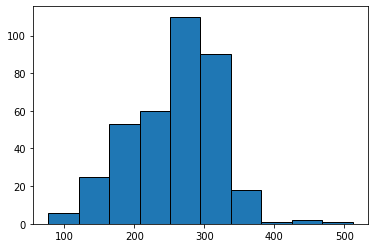

In [17]:
plt.hist(nehody, bins=10, range=(np.min(nehody),np.max(nehody)), edgecolor='black')
plt.show()

Histogram nevypadá úplně jako normální rozdělení, ale kdyby se 5. a 6. sloupec "uhladil", více by ho to
nejspíš připomínalo. Zkoušena byla ale i data z roku 2019, ta na první pohled opravdu připomínají hustotu normálního rozdělení.

Spočtěme nejdříve střední hodnotu (pomocí výběrového průměru) a rozptyl (pomocí výběrového rozptylu).

In [62]:
num_of_bins = 7
a = np.digitize(nehody, [0, 100, 200, 300, 400, 500, 600])
print(nehody.shape)
unique, counts = np.unique(a, return_counts=True)
out = dict(zip(unique, counts))

for i in range(0,num_of_bins):
    if i not in out:
        out[i] = 0
print(out)

hodnoty = []
keys_sorted = sorted(out.keys())
for k in keys_sorted:
    hodnoty.append(out[k])
print(hodnoty)

(366,)
{1: 2, 2: 76, 3: 181, 4: 103, 5: 3, 6: 1, 0: 0}
[0, 2, 76, 181, 103, 3, 1]


[0, 2, 76, 181, 103, 3, 1]


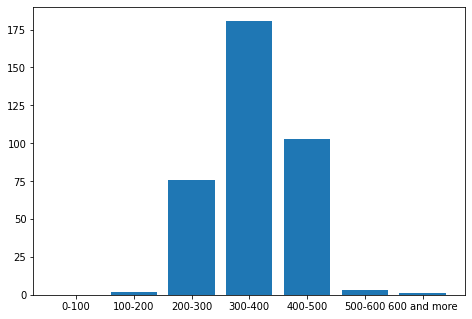

In [63]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
category = ["0-100", "100-200","200-300","300-400","400-500","500-600", "600 and more"]
numbers = list(dict(zip(keys_sorted, hodnoty)).values())
print(numbers)
ax.bar(category,numbers)
plt.show()